# Audio classification using convolutional neural networks

Audio classification can be performed by converting audio streams into [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which provide visual representations of spectrums of frequencies as they vary over time, and classifying the spectrograms using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs). 

Script modified from: https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb 

## Generate spectrograms

The first step is to load the WAV files, use a Python package named [Librosa](https://librosa.org/) to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [ ]:
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def butter_bandpass_filter(data, lowcut, highcut, sr, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def create_spectrogram(audio_file, image_file, lowcut=1000, highcut=10000):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)

    # Apply band-pass filter
    y_filtered = butter_bandpass_filter(y, lowcut=lowcut, highcut=highcut, sr=sr)

    ms = librosa.feature.melspectrogram(y=y_filtered, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        if file.endswith('.wav'):  # Ensure only processing .wav files
            input_file = os.path.join(input_path, file)
            output_file = os.path.join(output_path, file.replace('.wav', '.png'))
            create_spectrogram(input_file, output_file)


In [ ]:
os.getcwd()

Create PNG files containing spectrograms from all the WAV files in the "WAV_Files/Spotted_Towhee" directory.

In [ ]:
create_pngs_from_wavs('WAV_Files/TrainingSet/Spotted_Towhee_Train', 'Spectrograms/Spotted_Towhee_Train')

Create PNG files containing spectrograms from all the WAV files in the "WAV_Files/Eastern_Towhee" directory.

In [ ]:
create_pngs_from_wavs('WAV_Files/TrainingSet/Eastern_Towhee_Train', 'Spectrograms/Eastern_Towhee_Train')

Create PNG files containing spectrograms from all the WAV files in the "WAV_Files/TestSet/Eastern_Towhee_Test" directory.

In [ ]:
create_pngs_from_wavs('WAV_Files/TestSet/Eastern_Towhee_Test', 'Spectrograms/Eastern_Towhee_Test')

Create PNG files containing spectrograms from all the WAV files in the "WAV_Files/TestSet/Spotted_Towhee_Test" directory.

In [ ]:
create_pngs_from_wavs('WAV_Files/TestSet/Spotted_Towhee_Test', 'Spectrograms/Spotted_Towhee_Test')

Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [ ]:
#!pip install keras
#!pip install tensorflow

In [1]:
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        # Skip files that are not PNG
        if not file.endswith('.png'):
            continue  # Skip non-PNG files
        
        # Load the image and convert it to an array
        file_path = os.path.join(path, file)
        images.append(image.img_to_array(image.load_img(file_path, target_size=(224, 224, 3)))) 
        labels.append(label)
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

# Example usage
x_train = []
y_train = []
x_test = []
y_test = []

Load the Spotted towhee spectrogram images, add them to the list named `x`, and label them with 0s.

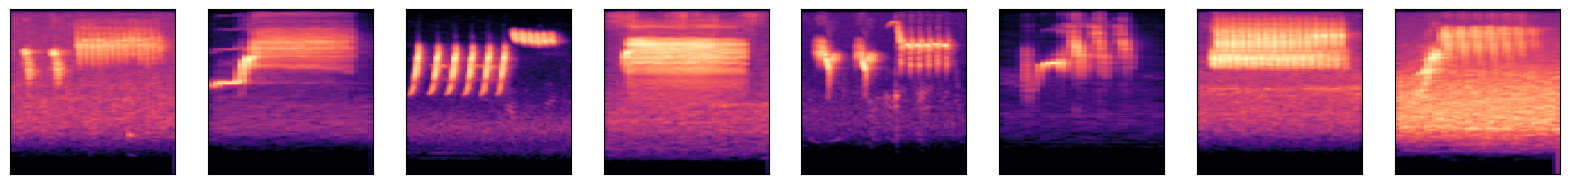

In [2]:
images, labels = load_images_from_path('Spectrograms/Spotted_Towhee_Train', 0)
show_images(images)
    
x_train += images
y_train += labels

Load the Eastern towhee spectrogram images, add them to the list named `x`, and label them with 1s.

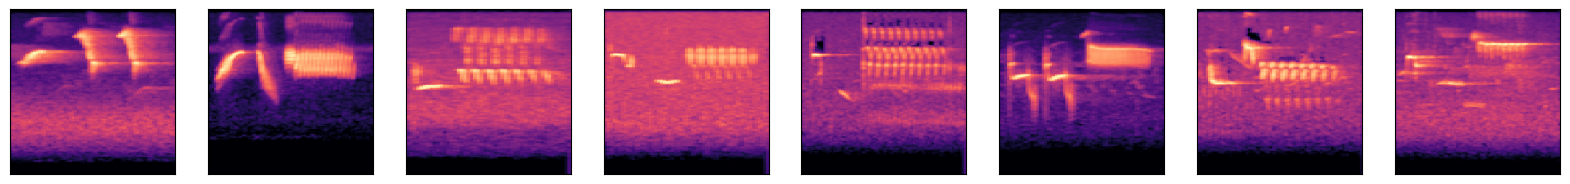

In [3]:
images, labels = load_images_from_path('Spectrograms/Eastern_Towhee_Train', 1)
show_images(images)
    
x_train += images
y_train += labels

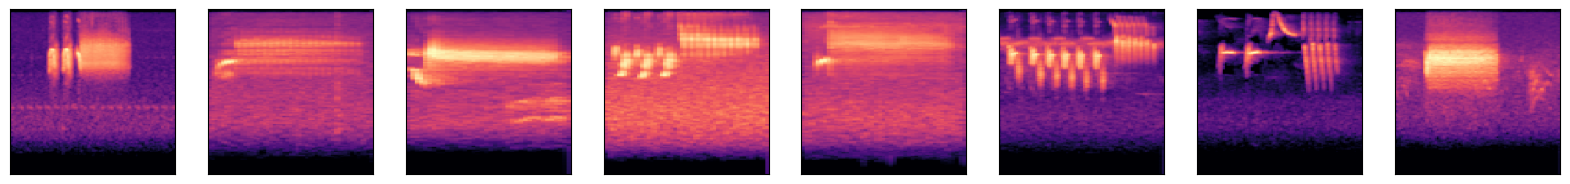

In [4]:
images, labels = load_images_from_path('Spectrograms/Spotted_Towhee_Test', 0)
show_images(images)
    
x_test += images
y_test += labels

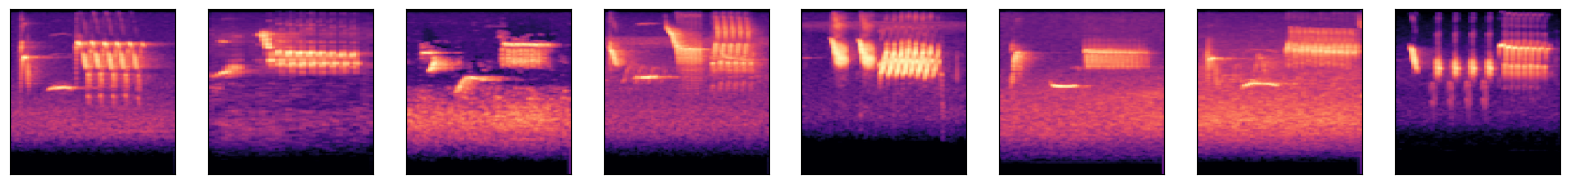

In [5]:
images, labels = load_images_from_path('Spectrograms/Eastern_Towhee_Test', 1)
show_images(images)
    
x_test += images
y_test += labels

Split the images and labels into two datasets — one for training, and one for testing. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function.

In [7]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

## Build and train a CNN

The next task is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, and a `softmax` layer that outputs probabilities for each class, and to train it with spectrogram images and labels. Start by defining the CNN.

## Using 3x3 pixel filters

In [8]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define function to create the model
def create_model3x3():
    model3x3 = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model3x3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model3x3

model3x3 = create_model3x3()
model3x3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,210,498 (73.28 MB)

 Trainable params: 19,210,498 (73.28 MB)

 Non-trainable params: 0 (0.00 B)

Run 1/10...
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step
Run 2/10...
Run 3/10...
Run 4/10...
Run 5/10...
Run 6/10...
Run 7/10...
Run 8/10...
Run 9/10...
Run 10/10...

Final Validation Accuracy of First Run (3x3 filter): 0.8752
Balanced Accuracy of First Run (3x3 filter): 0.8851
Cohen's Kappa of First Run (3x3 filter): 0.7457
Permutation Test p-value (3x3 filter): 0.0000


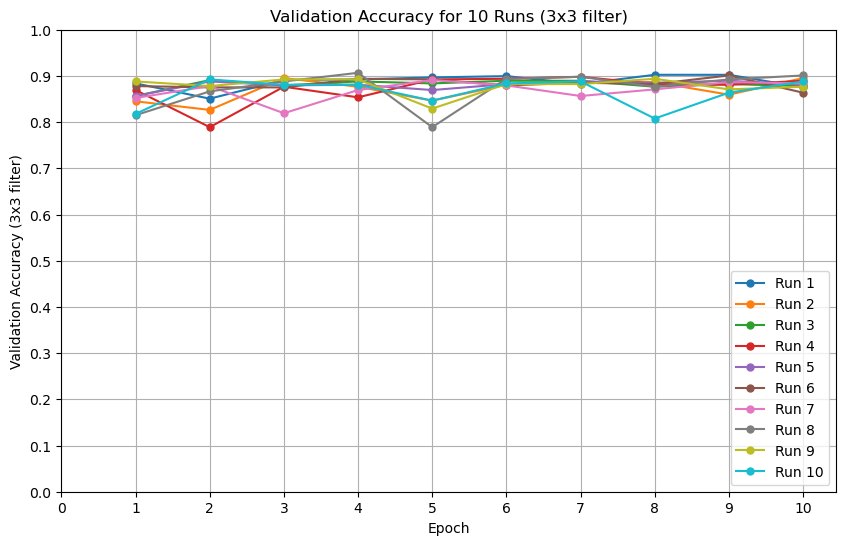

Average Validation Accuracy over 10 Runs (Last Epoch; 3x3 filter): 0.8832
Standard Deviation of Validation Accuracy over 10 Runs (Last Epoch; 3x3 filter): 0.0102
Validation Accuracy at Last Epoch for Each Run (3x3 filter):
[0.8751793503761292, 0.8952654004096985, 0.8780487775802612, 0.8895265460014343, 0.8809182047843933, 0.863701581954956, 0.8837876319885254, 0.9010043144226074, 0.8766140341758728, 0.8880918025970459]


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.utils import shuffle

# List to store validation accuracies for all runs
val_accuracies3x3 = []

# Loop to train the model 10 times
num_runs = 10
for i in range(num_runs):
    print(f"Run {i+1}/{num_runs}...")
    model3x3 = create_model3x3()  # Create a new model each time
    history = model3x3.fit(x_train_norm, y_train_encoded, 
                        validation_data=(x_test_norm, y_test_encoded),
                        batch_size=32, epochs=10, verbose=0)
    
    val_acc3x3 = history.history['val_accuracy']
    val_accuracies3x3.append(val_acc3x3)  # Directly append the list

    if i == 0:
        # Accuracy from the last epoch of first run
        first_run_final_acc3x3 = val_acc3x3[-1]

        # Get predictions and convert to label indices
        y_pred_probs = model3x3.predict(x_test_norm)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test_encoded, axis=1)

        # Balanced Accuracy
        first_run_balanced_acc3x3 = balanced_accuracy_score(y_true, y_pred)

        # Cohen's Kappa
        first_run_kappa3x3 = cohen_kappa_score(y_true, y_pred)

        # Permutation Test
        n_permutations = 1000
        permuted_scores = []
        for _ in range(n_permutations):
            y_perm = shuffle(y_true, random_state=None)
            score = balanced_accuracy_score(y_perm, y_pred)
            permuted_scores.append(score)
        
        permuted_scores = np.array(permuted_scores)
        permutation_p_value3x3 = np.mean(permuted_scores >= first_run_balanced_acc3x3)

# Print results for the first run
print(f"\nFinal Validation Accuracy of First Run (3x3 filter): {first_run_final_acc3x3:.4f}")
print(f"Balanced Accuracy of First Run (3x3 filter): {first_run_balanced_acc3x3:.4f}")
print(f"Cohen's Kappa of First Run (3x3 filter): {first_run_kappa3x3:.4f}")
print(f"Permutation Test p-value (3x3 filter): {permutation_p_value3x3:.4f}")

# Convert val_accuracies to a numpy array
val_accuracies3x3 = np.array(val_accuracies3x3)

# Plotting
epochs3x3 = range(1, len(val_accuracies3x3[0]) + 1)

plt.figure(figsize=(10, 6))
for i in range(num_runs):
    plt.plot(epochs3x3, val_accuracies3x3[i], label=f'Run {i+1}', linestyle='-', marker='o', markersize=5)

plt.title('Validation Accuracy for 10 Runs (3x3 filter)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (3x3 filter)')
plt.legend(loc='lower right')
plt.grid(True)

# Set custom ticks
plt.xticks(np.arange(0, len(epochs3x3) + 1, 1))  # from 0 to num_epochs, step 1
plt.yticks(np.arange(0.0, 1.05, 0.10))  # from 0 to 1, step 0.10
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.xlim(left=0)    # Ensure x-axis starts at 0

plt.savefig("CNN_3x3_ValidationAccuracy10Runs.pdf", format="pdf")
plt.show()

# Calculate the average and standard deviation of validation accuracy across all runs
avg_val_accuracy3x3 = np.mean(val_accuracies3x3, axis=0)
std_val_accuracy3x3 = np.std(val_accuracies3x3, axis=0)

# Print the results for the last epoch
print(f"Average Validation Accuracy over 10 Runs (Last Epoch; 3x3 filter): {avg_val_accuracy3x3[-1]:.4f}")
print(f"Standard Deviation of Validation Accuracy over 10 Runs (Last Epoch; 3x3 filter): {std_val_accuracy3x3[-1]:.4f}")

# Extract and print last epoch validation accuracy for each run
last_epoch_accuracies3x3 = [run_acc[-1] for run_acc in val_accuracies3x3]
print("Validation Accuracy at Last Epoch for Each Run (3x3 filter):")
print(last_epoch_accuracies3x3)



In [64]:
print(val_accuracies3x3)

[[0.88378763 0.85078907 0.89096129 0.89239597 0.89670014 0.89956957
  0.88235295 0.902439   0.902439   0.87517935]
 [0.84505022 0.82639885 0.8952654  0.87661403 0.84648496 0.8809182
  0.88665712 0.88665712 0.85939741 0.8952654 ]
 [0.85652798 0.89096129 0.87948352 0.8880918  0.88378763 0.88952655
  0.88952655 0.87661403 0.88235295 0.87804878]
 [0.86944044 0.78909612 0.87661403 0.85365856 0.89239597 0.89383072
  0.89813489 0.88235295 0.8809182  0.88952655]
 [0.85652798 0.8880918  0.87948352 0.8809182  0.86944044 0.88235295
  0.8880918  0.88522238 0.88952655 0.8809182 ]
 [0.87804878 0.87517935 0.87517935 0.89383072 0.89239597 0.87948352
  0.88522238 0.88235295 0.90100431 0.86370158]
 [0.85222381 0.87804878 0.81922525 0.86944044 0.89096129 0.87948352
  0.85652798 0.87087518 0.88665712 0.88378763]
 [0.81492108 0.86657101 0.8880918  0.90674317 0.78909612 0.89383072
  0.89813489 0.87661403 0.89239597 0.90100431]
 [0.8880918  0.87804878 0.89239597 0.89239597 0.82926828 0.88235295
  0.88235295 

Run the test images through the network and use a confusion matrix to assess the results.

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


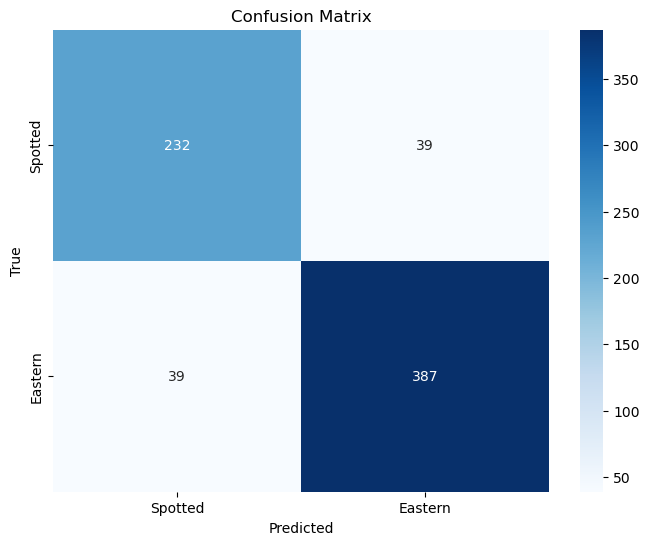

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Get predictions from the model
# Assuming x_test_norm is your test data
y_pred_prob = model3x3.predict(x_test_norm)  # Get predicted probabilities #test_features
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Step 2: Get the true labels (y_test_encoded) and convert to class labels
y_true = np.argmax(y_test_encoded, axis=1)  # Assuming y_test_encoded is one-hot encoded

# Step 3: Create the confusion matrix
cm3x3 = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm3x3, annot=True, fmt='d', cmap='Blues', xticklabels=['Spotted', 'Eastern'], yticklabels=['Spotted', 'Eastern'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Using 5x5 pixel filter

In [67]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define function to create the model
def create_model5x5():
    model5x5 = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model5x5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model5x5

model5x5 = create_model5x5()
model5x5.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_104 (Conv2D)             │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 110, 110, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 106, 106, 128)  │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 53, 53, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 49, 49, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 24, 24, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 20, 20, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 10, 10, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,034,690 (53.54 MB)

 Trainable params: 14,034,690 (53.54 MB)

 Non-trainable params: 0 (0.00 B)

Run 1/10...
22/22 ━━━━━━━━━━━━━━━━━━━━ 1068s 51s/step
Run 2/10...
Run 3/10...
Run 4/10...
Run 5/10...
Run 6/10...
Run 7/10...
Run 8/10...
Run 9/10...
Run 10/10...

Final Validation Accuracy of First Run (5x5 filter): 0.9154
Balanced Accuracy of First Run (5x5 filter): 0.9066
Cohen's Kappa of First Run (5x5 filter): 0.8203
Permutation Test p-value (5x5 filter): 0.0000


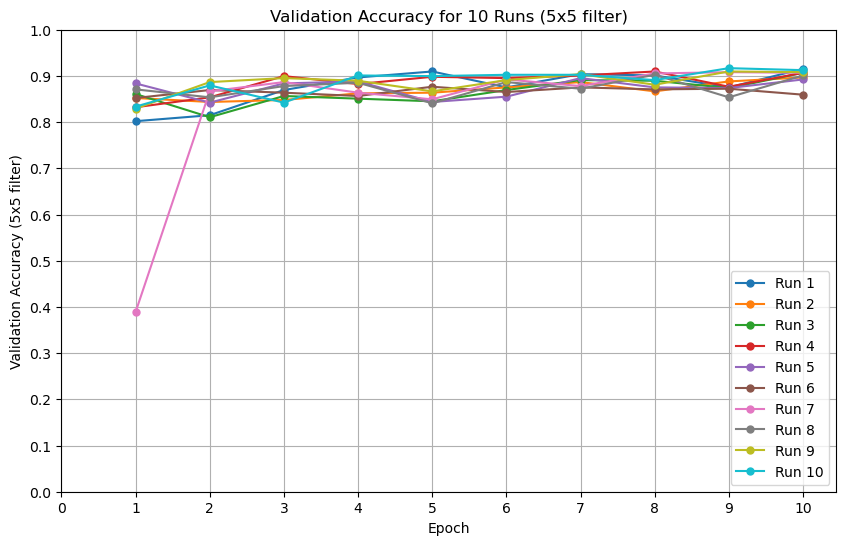

Average Validation Accuracy over 10 Runs (Last Epoch; 5x5 filter): 0.9006
Standard Deviation of Validation Accuracy over 10 Runs (Last Epoch; 5x5 filter): 0.0152
Validation Accuracy at Last Epoch for Each Run (5x5 filter):
[0.9153515100479126, 0.8967001438140869, 0.9067431688308716, 0.9067431688308716, 0.8923959732055664, 0.8593974113464355, 0.9067431688308716, 0.9010043144226074, 0.90817791223526, 0.9124820828437805]


In [68]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.utils import shuffle

# List to store validation accuracies for all runs
val_accuracies5x5 = []

# Loop to train the model 10 times
num_runs = 10
for i in range(num_runs):
    print(f"Run {i+1}/{num_runs}...")
    model5x5 = create_model5x5()  # Create a new model each time
    history = model5x5.fit(x_train_norm, y_train_encoded, 
                        validation_data=(x_test_norm, y_test_encoded),
                        batch_size=32, epochs=10, verbose=0)
    
    val_acc5x5 = history.history['val_accuracy']
    val_accuracies5x5.append(val_acc5x5)  # Directly append the list

    if i == 0:
        # Accuracy from the last epoch of first run
        first_run_final_acc5x5 = val_acc5x5[-1]

        # Get predictions and convert to label indices
        y_pred_probs = model5x5.predict(x_test_norm)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test_encoded, axis=1)

        # Balanced Accuracy
        first_run_balanced_acc5x5 = balanced_accuracy_score(y_true, y_pred)

        # Cohen's Kappa
        first_run_kappa5x5 = cohen_kappa_score(y_true, y_pred)

        # Permutation Test
        n_permutations = 1000
        permuted_scores = []
        for _ in range(n_permutations):
            y_perm = shuffle(y_true, random_state=None)
            score = balanced_accuracy_score(y_perm, y_pred)
            permuted_scores.append(score)
        
        permuted_scores = np.array(permuted_scores)
        permutation_p_value5x5 = np.mean(permuted_scores >= first_run_balanced_acc5x5)

# Print results for the first run
print(f"\nFinal Validation Accuracy of First Run (5x5 filter): {first_run_final_acc5x5:.4f}")
print(f"Balanced Accuracy of First Run (5x5 filter): {first_run_balanced_acc5x5:.4f}")
print(f"Cohen's Kappa of First Run (5x5 filter): {first_run_kappa5x5:.4f}")
print(f"Permutation Test p-value (5x5 filter): {permutation_p_value5x5:.4f}")

# Convert val_accuracies to a numpy array
val_accuracies5x5 = np.array(val_accuracies5x5)

# Plotting
epochs5x5 = range(1, len(val_accuracies5x5[0]) + 1)

plt.figure(figsize=(10, 6))
for i in range(num_runs):
    plt.plot(epochs5x5, val_accuracies5x5[i], label=f'Run {i+1}', linestyle='-', marker='o', markersize=5)

plt.title('Validation Accuracy for 10 Runs (5x5 filter)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (5x5 filter)')
plt.legend(loc='lower right')
plt.grid(True)

# Set custom ticks
plt.xticks(np.arange(0, len(epochs5x5) + 1, 1))  # from 0 to num_epochs, step 1
plt.yticks(np.arange(0.0, 1.05, 0.10))  # from 0 to 1, step 0.10
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.xlim(left=0)    # Ensure x-axis starts at 0

plt.savefig("CNN_5x5_ValidationAccuracy10Runs.pdf", format="pdf")
plt.show()

# Calculate the average and standard deviation of validation accuracy across all runs
avg_val_accuracy5x5 = np.mean(val_accuracies5x5, axis=0)
std_val_accuracy5x5 = np.std(val_accuracies5x5, axis=0)

# Print the results for the last epoch
print(f"Average Validation Accuracy over 10 Runs (Last Epoch; 5x5 filter): {avg_val_accuracy5x5[-1]:.4f}")
print(f"Standard Deviation of Validation Accuracy over 10 Runs (Last Epoch; 5x5 filter): {std_val_accuracy5x5[-1]:.4f}")

# Extract and print last epoch validation accuracy for each run
last_epoch_accuracies5x5 = [run_acc[-1] for run_acc in val_accuracies5x5]
print("Validation Accuracy at Last Epoch for Each Run (5x5 filter):")
print(last_epoch_accuracies5x5)

## Using 7x7 pixel filter

In [69]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define function to create the model
def create_model7x7():
    model7x7 = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (7, 7), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model7x7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model7x7

model7x7 = create_model7x7()
model7x7.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_148 (Conv2D)             │ (None, 218, 218, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 109, 109, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 103, 103, 128)  │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 51, 51, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 45, 45, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 16, 16, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 8, 8, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,203,138 (38.92 MB)

 Trainable params: 10,203,138 (38.92 MB)

 Non-trainable params: 0 (0.00 B)

Run 1/10...
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 483ms/step
Run 2/10...
Run 3/10...
Run 4/10...
Run 5/10...
Run 6/10...
Run 7/10...
Run 8/10...
Run 9/10...
Run 10/10...

Final Validation Accuracy of First Run (7x7 filter): 0.8867
Balanced Accuracy of First Run (7x7 filter): 0.8959
Cohen's Kappa of First Run (7x7 filter): 0.7685
Permutation Test p-value (7x7 filter): 0.0000


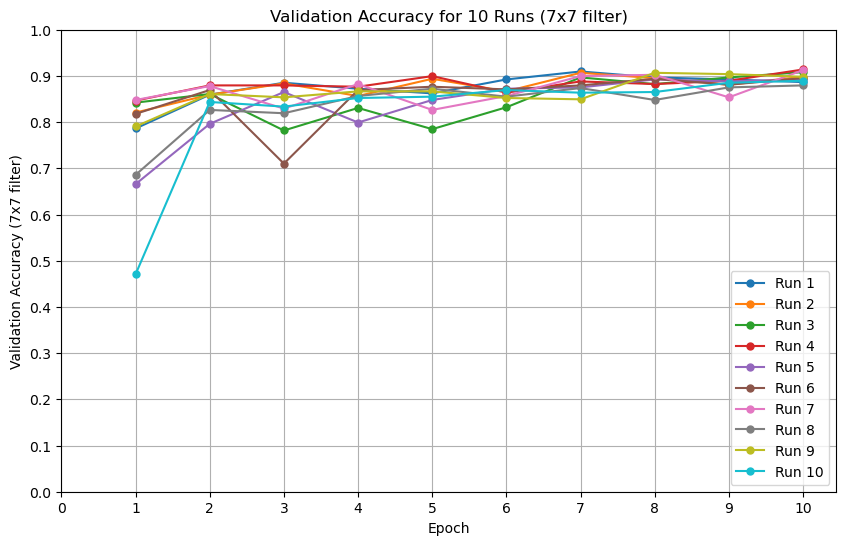

Average Validation Accuracy over 10 Runs (Last Epoch; 7x7 filter): 0.8974
Standard Deviation of Validation Accuracy over 10 Runs (Last Epoch; 7x7 filter): 0.0107
Validation Accuracy at Last Epoch for Each Run (7x7 filter):
[0.8866571187973022, 0.8981348872184753, 0.90817791223526, 0.9139167666435242, 0.8923959732055664, 0.8952654004096985, 0.9124820828437805, 0.8794835209846497, 0.8981348872184753, 0.8895265460014343]


In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.utils import shuffle

# List to store validation accuracies for all runs
val_accuracies7x7 = []

# Loop to train the model 10 times
num_runs = 10
for i in range(num_runs):
    print(f"Run {i+1}/{num_runs}...")
    model7x7 = create_model7x7()  # Create a new model each time
    history = model7x7.fit(x_train_norm, y_train_encoded, 
                        validation_data=(x_test_norm, y_test_encoded),
                        batch_size=32, epochs=10, verbose=0)
    
    val_acc7x7 = history.history['val_accuracy']
    val_accuracies7x7.append(val_acc7x7)  # Directly append the list

    if i == 0:
        # Accuracy from the last epoch of first run
        first_run_final_acc7x7 = val_acc7x7[-1]

        # Get predictions and convert to label indices
        y_pred_probs = model7x7.predict(x_test_norm)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test_encoded, axis=1)

        # Balanced Accuracy
        first_run_balanced_acc7x7 = balanced_accuracy_score(y_true, y_pred)

        # Cohen's Kappa
        first_run_kappa7x7 = cohen_kappa_score(y_true, y_pred)

        # Permutation Test
        n_permutations = 1000
        permuted_scores = []
        for _ in range(n_permutations):
            y_perm = shuffle(y_true, random_state=None)
            score = balanced_accuracy_score(y_perm, y_pred)
            permuted_scores.append(score)
        
        permuted_scores = np.array(permuted_scores)
        permutation_p_value7x7 = np.mean(permuted_scores >= first_run_balanced_acc7x7)

# Print results for the first run
print(f"\nFinal Validation Accuracy of First Run (7x7 filter): {first_run_final_acc7x7:.4f}")
print(f"Balanced Accuracy of First Run (7x7 filter): {first_run_balanced_acc7x7:.4f}")
print(f"Cohen's Kappa of First Run (7x7 filter): {first_run_kappa7x7:.4f}")
print(f"Permutation Test p-value (7x7 filter): {permutation_p_value7x7:.4f}")

# Convert val_accuracies to a numpy array
val_accuracies7x7 = np.array(val_accuracies7x7)

# Plotting
epochs7x7 = range(1, len(val_accuracies7x7[0]) + 1)

plt.figure(figsize=(10, 6))
for i in range(num_runs):
    plt.plot(epochs7x7, val_accuracies7x7[i], label=f'Run {i+1}', linestyle='-', marker='o', markersize=5)

plt.title('Validation Accuracy for 10 Runs (7x7 filter)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (7x7 filter)')
plt.legend(loc='lower right')
plt.grid(True)

# Set custom ticks
plt.xticks(np.arange(0, len(epochs7x7) + 1, 1))  # from 0 to num_epochs, step 1
plt.yticks(np.arange(0.0, 1.05, 0.10))  # from 0 to 1, step 0.10
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.xlim(left=0)    # Ensure x-axis starts at 0

plt.savefig("CNN_7x7_ValidationAccuracy10Runs.pdf", format="pdf")
plt.show()

# Calculate the average and standard deviation of validation accuracy across all runs
avg_val_accuracy7x7 = np.mean(val_accuracies7x7, axis=0)
std_val_accuracy7x7 = np.std(val_accuracies7x7, axis=0)

# Print the results for the last epoch
print(f"Average Validation Accuracy over 10 Runs (Last Epoch; 7x7 filter): {avg_val_accuracy7x7[-1]:.4f}")
print(f"Standard Deviation of Validation Accuracy over 10 Runs (Last Epoch; 7x7 filter): {std_val_accuracy7x7[-1]:.4f}")

# Extract and print last epoch validation accuracy for each run
last_epoch_accuracies7x7 = [run_acc[-1] for run_acc in val_accuracies7x7]
print("Validation Accuracy at Last Epoch for Each Run (7x7 filter):")
print(last_epoch_accuracies7x7)